# External model tutorial

In this tutorial you will learn the basics of the model interface for running an external model. The API for the model interface is provided [here](https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html).


## Modules
Here are the relevant modules for this example.

In [1]:
%%capture
import romtools
import numpy as np
from matplotlib import pyplot as plt
from romtools.workflows import models
import os

[s1067086ca:26909] shmem: mmap: an error occurred while determining whether or not /var/folders/cl/5gkmlky11v3_hw7tzm3l_y6h003hgz/T//ompi.s1067086ca.115199/jf.0/3880255488/sm_segment.s1067086ca.115199.e7480000.0 could be created.


## Model Definition
Here, we will interface around a model for solving the 1D advection diffusion problem.
The model code is given in `adr_1d/adr_1d.py`, and it solves the 1d advection diffusion equation:

$$
c u_{x} - \nu * u_{xx} = 1
$$

To run the code, a file `params.dat` is required in the run directory. 
This `.dat` file contains the parameters $c$, $\nu$. 
Running the code outputs a solution.npz file with the keys $x$ (grid) and $u$ (solution).

Here is an example of how we would run the code:

0

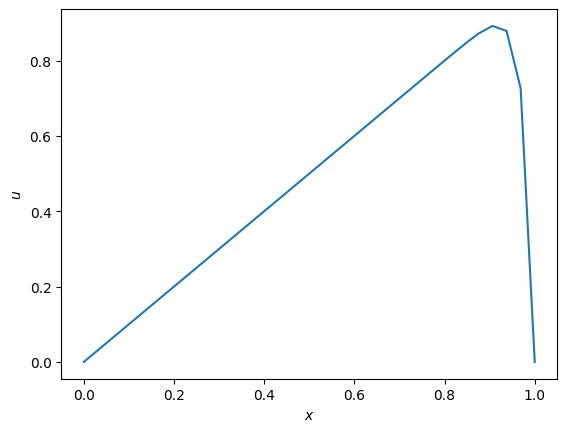

In [2]:
#First, let's create our parameters
c = 1.
nu = 1.e-2
#Now, we will save them to a file expected by the adr_1d.py code
np.savetxt('params.dat',np.array([c,nu]))

#This is how we would execute our external code
#(For a more sophisticated application, this is likely an mpi call to an executable or
# a submission to the HPCs)
os.system('python adr_1d/adr_1d.py')

#Let's take a peak at a solution
sol = np.load('solution.npz')
plt.plot(sol['x'],sol['u'])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

# Now we will clean up the files we created
os.system('rm params.dat')
os.system('rm solution.npz')

## Model Class Definition
Now, let's create a romtools wrapper around this model that meets the API of the `ModelClass`.

In [3]:
class adrExternalRomToolsModel:
    def __init__(self):
        # Get path to adr code
        self.exec_dir_ = os.getcwd() + '/adr_1d/'
        
    def populate_run_directory(self, run_directory: str, parameter_sample: dict):
        # Here, we need to make a params.dat file in the run_directory
        c = parameter_sample['c']
        nu = parameter_sample['nu']
        np.savetxt(run_directory + '/params.dat',np.array([c,nu]))
        
    def run_model(self, run_directory: str, parameter_sample: dict):
        starting_dir = os.getcwd()
        os.chdir(run_directory)
        os.system('python ' + self.exec_dir_ + 'adr_1d.py')
        #To avoid confusion, we will move back to the directory we started from
        os.chdir(starting_dir)
        return 0

Let's initialize the model.

In [4]:
adr_for_romtools = adrExternalRomToolsModel()

That's it, we can use this in a sampling workflow.

## Example
Let's do an example run of the model similar to how it will be used in a workflow.

First, let's make a dictionary that is a stand in for the parameter space.

In [5]:
parameter_sample = {}
parameter_sample['c'] = 0.5
parameter_sample['nu'] = 1e-1

Now, let's populate our run directory. In this example, we will just use the current run directory.
In a full workflow, romtools will manage creating directories.

In [6]:
adr_for_romtools.populate_run_directory(os.getcwd(),parameter_sample)

Now, let's run the model and view the solution.

Text(0, 0.5, '$u$')

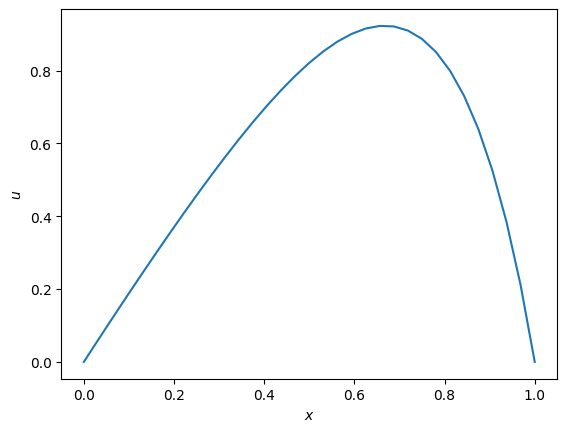

In [7]:
adr_for_romtools.run_model(os.getcwd(),parameter_sample)

#We can look at a solution
sol = np.load('solution.npz')
plt.plot(sol['x'],sol['u'])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

We will finish by cleaning up the files we created

In [8]:
%%capture
os.system('rm params.dat')
os.system('rm solution.npz')

That's it! See the sampling tutorial for an example of how this model is used in a sampling workflow.